# Gender image categorization using neural networks


## Author: Ángel López Manríquez


### Objectives: 
Given an image with only one face, determine its gender.
### What is done in the Notebook: 
Preprocessing the data and the use of several classifiers algorithms.

In [24]:
# Fundamental datascience libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2  # computer vision 2 library
import cvlib as cv  # face feature
import keras

# standard python modules
import random
import os
import urllib.request  # fetch images from an url

# keras stuff
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split



from IPython.display import display, HTML, Markdown  # exclusive for jupyter notebook
from tqdm import tqdm  # Very cool progress bar :D
from typing import List, Tuple  # Explicit declaration type for collections, python 3.7+
from collections import Counter  # counts how many instance we have

from sklearn import preprocessing

In [2]:
plt.style.use('seaborn')  # improve plot style

def display_markdown(*args, **kargs):
    '''The main use of is beeing able to display something in a notebook from another function.'''
    display(Markdown(*args, **kargs))

## Data visualization
By loading the dataset, we realize the we only care about the image url and the gender label, everything else is useless. 

In [3]:
fname = 'a943287.csv'  # dataset name
df = pd.read_csv(fname)
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,please_select_the_gender_of_the_person_in_the_picture,please_select_the_gender_of_the_person_in_the_picture:confidence,image_url,please_select_the_gender_of_the_person_in_the_picture_gold,user_id
0,1023132475,False,finalized,1,8/19/2016 17:00:25,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/40...,NaN,40
1,1023132476,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/42...,NaN,42
2,1023132477,False,finalized,1,8/19/2016 17:01:43,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/44...,NaN,44
3,1023132478,False,finalized,1,8/19/2016 17:01:04,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/47...,NaN,47
4,1023132479,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/50...,NaN,50


Let's count the number of instances per class.



In [4]:
gender_labels = df.please_select_the_gender_of_the_person_in_the_picture.values
counter = Counter(gender_labels)
display(counter)  # display unique label values

Counter({'male': 47595, 'female': 7367, 'unsure': 9122})

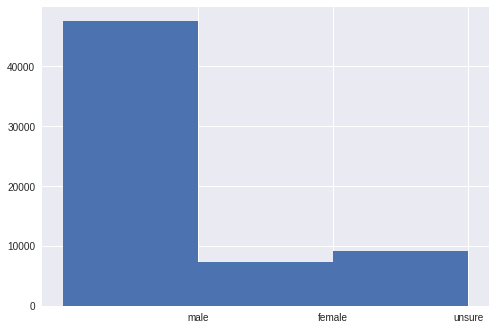

In [5]:
labels, values = zip(*counter.items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

We realize there are some images which does not contain faces, tagged as 'unsure', we will drop them.
Also, we have more samples for man than woman, Our approach will be training the model with the same amount of man and woman faces.

In [6]:
display('''Lenght with "unsure" labels''', df.shape)
df = df[df.please_select_the_gender_of_the_person_in_the_picture != 'unsure']  # drop irrelevant rows
display('''Lenght without "unsure" labels''', df.shape)

'Lenght with "unsure" labels'

(64084, 10)

'Lenght without "unsure" labels'

(54962, 10)

In [7]:
df = df[['image_url', 'please_select_the_gender_of_the_person_in_the_picture']]
df.rename(columns={'image_url':'url',
                          'please_select_the_gender_of_the_person_in_the_picture':'gender'}, 
                 inplace=True)

display(df.head())


,url,gender
0,https://d1qb2nb5cznatu.cloudfront.net/users/40...,male
1,https://d1qb2nb5cznatu.cloudfront.net/users/42...,male
2,https://d1qb2nb5cznatu.cloudfront.net/users/44...,male
3,https://d1qb2nb5cznatu.cloudfront.net/users/47...,male
4,https://d1qb2nb5cznatu.cloudfront.net/users/50...,male


In [8]:

X = df['url'].values  # list of urls where will be able to download the image
y = df['gender'].values


### Setting the dataset
Now, let's download the dataset. We will download the images, create directoris img, img/male, img/female and store the images in the corresponding directory.

Some images could not be downloaded (they doesn't exists anymore), some of them could not be opened, we discard them.

In [9]:

def make_dir(folder: str) -> None:
    '''Create the folder even, if it exists no changes or exceptions will be executed. '''
    if not os.path.exists(folder):
        os.mkdir(folder)

def save_img(img_url: str, filepath: str) -> np.array:
    '''Create the file and save it, if we cannot download it an exception will be raised.
    We may return a None object, meaning that we could not open the image (very weird scenario). '''
    try:
        with urllib.request.urlopen(img_url) as url:
            s = url.read()  # read the image in the website if posible.
    except urllib.error.HTTPError as e:
        print(e)
        raise
    with open(filepath, 'wb') as f:
        f.write(s)  # save the image
    return cv2.imread(filepath)  # return the image as np.array


In [10]:
def download_males_females(df, n: int, label_names=['female', 'male']):
    '''Download n images for each gender.'''
    i = 0
    imgs, labels = [], []  # define containers
    for name, group in df.groupby('gender'):  # group them, we attempt to balance the number of instances
        download_count = 0 
        for row_index, row in group.iterrows():
            try:
                fpath = os.path.join('img', row['gender'], f'{i}.jpeg')
                im = save_img(row['url'], fpath)  # exception may occur here
                if im is None:  # The image exists, we store it but we couldn't opened it. Remove it and try the next one
                    if os.path.exists(fpath): os.remove(fpath)
                    print(f'Cannot open {fpath}')
                    continue
                imgs.append(im)
                labels.append(row['gender'])
                download_count += 1
                print(f' {download_count} / {n}', end='  ')
            except urllib.error.HTTPError:
                print(f'Image {i} could not be download or open, trying the next one.')
            i += 1
            if download_count == n: break  # We have reached the number of instances required
    return imgs, labels


In [11]:
def gender_imgs(gender: str, n: int) -> List[np.array]:
    '''Returns an array for the first n images in the directory, gender must be male or female.'''
    subdir = os.path.join('img', gender)
    bnames = list(os.listdir(subdir))
    bnames.sort()  # sort the content, by default listdir doesn't guarantee the result sorted
    bnames = bnames[:n]
    # result = [cv2.imread(os.path.join(subdir, bname), cv2.IMREAD_GRAYSCALE) for bname in bnames]
    result = [cv2.imread(os.path.join(subdir, bname)) for bname in bnames]
    return result

def get_dataset(n: int):
    '''Store the dataset, we suppose the images are already downloaded in each directory. '''
    males = gender_imgs('male', n)
    females = gender_imgs('female', n)
    X = females
    y = [0 for _ in females]
    X += males
    y += [1 for _ in males]
    return X, y

In [12]:

def set_local_dataset(df, n: int) -> Tuple[list, list]:
    '''Returns a tuple of list X, y. Each x in X will be an image as np.array.'''
    make_dir('img')
    make_dir(os.path.join('img', 'male'))
    make_dir(os.path.join('img', 'female'))
    
    male_img_length = len(os.listdir(os.path.join('img', 'male')))
    female_img_length = len(os.listdir(os.path.join('img', 'female')))
    
    if male_img_length >= n and female_img_length >= n:  # we have enough images downloaded
        return get_dataset(n)
    return download_males_females(df, n)



In [13]:
X, y = set_local_dataset(df, 512)  # set a list of images as np.array



### Preprocess the image
Now, we need to apply feature extraction, we only care for faces rather than all the scenario. We obtain the faces from the image and train the model with them. The process is very straightforward with the cvlib library.



In [14]:


def faces_from_image(image: np.array) -> np.array:
    '''Given an image as np.array, we return a list of faces with a size of (96, 96). 
    If there're no faces, we return an empty list, if we cannot resize the image we return a None object. '''
    faces = []
    face, confidence = cv.detect_face(image)  
    for f in face:  # loop through each face
        (startX, startY) = f[0], f[1]  # get the corners for each image
        (endX, endY) = f[2], f[3]
        # cv2.rectangle(image, (startX,startY), (endX,endY), (0,255,0), 2)  # draw rectangle over face
        face_crop = np.copy(image[startY:endY, startX:endX])  # crop the detected face region
        try:
            face_crop = cv2.resize(face_crop, (96,96))   # Resize every single image for the neural network
        except Exception as e: 
            return None  # We cannot resize the desire image
        face_crop = face_crop.astype("float") / 255.0  # normalize the image, as type float
        face_crop = img_to_array(face_crop)  # pass image to array
        # face_crop = np.expand_dims(face_crop, axis=0)
        faces.append(face_crop)
    return np.array(faces)



In [15]:
# December 9, exam
# last two weeks, oral presentation

def plot_img(img):
    plt.imshow(img)
    plt.show()

In [16]:

def get_faces(X: list, y: list):
    '''Extract the images X, y such that we could actually extract a face and could resize it.'''
    x_faces, y_faces = [], []  # to return
    unvalid_indexes = list()
    for i, image in tqdm(enumerate(X)):
        faces = faces_from_image(image)  # get the faces list
        if faces is None or faces.shape[0] == 0:  
            unvalid_indexes.append(i)
            continue
        # if we could resize face of the image and there are people in the image
        x_faces.append(faces[0])  # append the first face 
        y_faces.append(y[i])  # append the label
    return np.array(x_faces), np.array(y_faces), unvalid_indexes  # return filtered X, y



In [ ]:
# # before 
# print(len(X))
# print(len(y))

# X, y = get_faces(X, y)

# # after
# print(X_faces.shape)
# print(y_faces.shape)

In [18]:

# set a label 
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)  
print(le.classes_)


# train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train_faces, y_train_faces, _ = get_faces(X_train, y_train)
X_test_faces, y_test_faces, indexes = get_faces(X_test, y_test)
np.delete(X_test, indexes)
np.delete(y_test, indexes)

y_train_one_hot = to_categorical(y_train_faces)
y_test_one_hot = to_categorical(y_test_faces)


[0 1]


## Training the model
After preprocessing all the images, droping those labeled as unknown, droping no clear images we finally build the model. We design a simple architecture for the neural network, without using deep neural networks we actually took good results.

In [20]:


def Model(shape, n_outputs):
    '''Build the architecture fo the model.'''
    model = Sequential()
    
    model.add(Flatten(input_shape=shape))  # Flat the image given
    model.add(Dense(128, activation='relu'))  # connect every neuron to each other, obtain relevan features with Relu activation function
    
    model.add(Dense(n_outputs, activation='softmax'))  # final layer, since we have two classes we need two neurons in the final layer
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


model = Model(X_train[0].shape, 2)  # pass the shape of the first instance, of course ALL instances must share the same shape
model.fit(X_train, y_train_one_hot, epochs=20)  # fit the model, the dependent variable must be one hot, of course
test_loss, test_acc = model.evaluate(X_test,  y_test_one_hot, verbose=2)  # evaluate the model, display how accurately it is
print('\nTest accuracy:', test_acc)

Epoch 1/20
688/688 [==============================] - 1s 2ms/step - loss: 3.6648 - accuracy: 0.6512
Epoch 2/20
688/688 [==============================] - 1s 2ms/step - loss: 0.5793 - accuracy: 0.7645
Epoch 3/20
688/688 [==============================] - 1s 2ms/step - loss: 0.6953 - accuracy: 0.7456
Epoch 4/20
688/688 [==============================] - 1s 1ms/step - loss: 0.5596 - accuracy: 0.7660
Epoch 5/20
688/688 [==============================] - 1s 2ms/step - loss: 0.6319 - accuracy: 0.7674
Epoch 6/20
688/688 [==============================] - 1s 1ms/step - loss: 0.3881 - accuracy: 0.8328
Epoch 7/20
688/688 [==============================] - 1s 2ms/step - loss: 0.4120 - accuracy: 0.8140
Epoch 8/20
688/688 [==============================] - 1s 2ms/step - loss: 0.3445 - accuracy: 0.8387
Epoch 9/20
688/688 [==============================] - 1s 2ms/step - loss: 0.3389 - accuracy: 0.8430
Epoch 10/20
688/688 [==============================] - 1s 2ms/step - loss: 0.3101 - accuracy: 0.8605

### Conclusion


In [22]:
type(model)

keras.engine.sequential.Sequential

In [25]:
def conclusion(image: np.array, model: keras.engine.sequential.Sequential) -> None:
    face, confidence = cv.detect_face(image)  
    for f in face:  # loop through each face
        (startX, startY) = f[0], f[1]  # get the corners for each image
        (endX, endY) = f[2], f[3]
        cv2.rectangle(image, (startX,startY), (endX,endY), (0,255,0), 2)  # draw rectangle over face
        face_crop = np.copy(image[startY:endY, startX:endX])  # crop the detected face region

        # preprocessing for gender detection model
        try:
            face_crop = cv2.resize(face_crop, (96,96))   # Resize every single image for the neural network
        except Exception as e: 
            continue
        face_crop = face_crop.astype("float") / 255.0  # normalize the image, as type float
        face_crop = img_to_array(face_crop)  # pass image to array
        face_crop = np.expand_dims(face_crop, axis=0)

        # apply gender detection on face
        conf = model.predict(face_crop)[0]
        print(conf)
        print(classes)

        # get label with max accuracy
        idx = np.argmax(conf)
        label = classes[idx]

        label = "{}: {:.2f}%".format(label, conf[idx] * 100)

        Y = startY - 10 if startY - 10 > 10 else startY + 10

        # write label and confidence above face rectangle
        cv2.putText(image, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    plot_img(image)

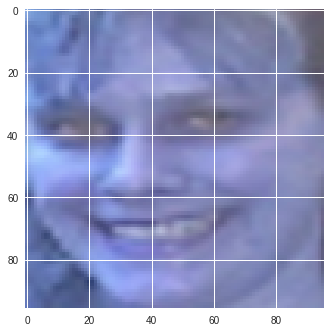

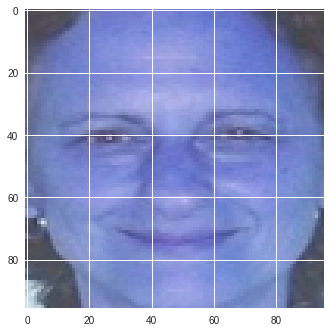

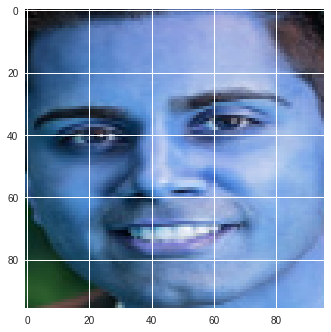

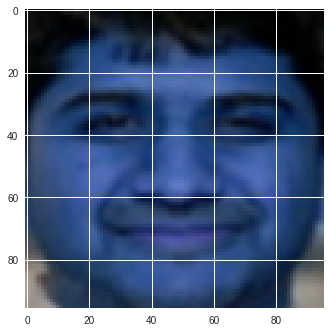

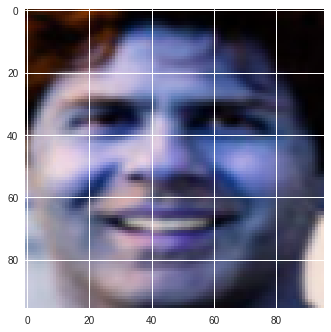

In [28]:
import random

for img in random.sample(list(X), k=5):
    conclusion(img, model)